# Install libraries

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
 pip install tensorflow-gpu==1.15.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow-gpu==1.15.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras==2.2.4

Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install git

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qzn91aio
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qzn91aio
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [43]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4jp19k4x
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4jp19k4x
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


# Data loader

In [6]:
# Maximum length of comment
max_len = 128 
# Dimension of embedding vector
embedding_dim = 100 
# Max feature
max_feature = 10000

In [7]:
# Read data
import pandas as pd
from ast import literal_eval

data = pd.read_csv('/home/harsh/Downloads/tsd_train.csv')
dev = pd.read_csv('/home/harsh/Downloads/tsd_trial.csv')
test = pd.read_csv('/home/harsh/Downloads/tsd_test.csv')

text_data = data['text'].values
spans = data['spans'].apply(literal_eval)
lbl = [1 if len(s) > 0 else 0 for s in spans]

text_data_test = test['text'].values
spans_test = test['spans'].apply(literal_eval)
test_id = test.index
lbl_test = [1 if len(s) > 0 else 0 for s in spans_test]

text_data_dev = dev['text'].values
spans_dev = dev['spans'].apply(literal_eval)
dev_id = dev.index
lbl_dev = [1 if len(s) > 0 else 0 for s in spans_dev]

In [8]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install -U spacy[cuda113]

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Token level 

from nltk.tokenize import TweetTokenizer
import numpy as np
# import spacy

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    return tknzr2.tokenize(text_data)

def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1]-1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def span_retrived(text_data, spans):
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))
    
    return token_labels

def span_convert(text_data, spans):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))

    lst_seq = []
    for i in range(0, len(text_data)):
        # token = tknzr.tokenize(text_data[i])
        token = custom_tokenizer(text_data[i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                # if token[j] in tknzr.tokenize(t):
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)     

    return (token_labels, lst_seq)

In [12]:
from copy import deepcopy

# convert data
data['token'], data['seq'] = span_convert(text_data, spans)
dev['token'], dev['seq'] = span_convert(text_data_dev, spans_dev)
test['token'], test['seq'] = span_convert(text_data_test, spans_test)

train = deepcopy(data)
data = pd.concat([data, dev])

# Evaluation metric 

In [13]:
# Evaluation metric

import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # # read the predictions
    # pred_lines = pred.readlines()
    # # read the ground truth
    # gold_lines = gold.readlines()

    pred_lines = pred
    gold_lines = gold

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

# Data analysis 

In [14]:
# Number of training data
print(len(train))

7939


In [15]:
# Number of test data
print(len(test))

2000


In [16]:
test

,spans,text,token,seq
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",That's right. They are not normal. And I am st...,"[ABNORMAL, sexist rubbish]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt...",[stupid],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[],tens years ago i contacted the PDR and suggest...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[],The parallels between the ANC and the Sicilian...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[],Intel Community: ‘How can we work for a Presid...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1995,"[4, 5, 6, 7, 8, 70, 71, 72, 73, 74, 75, 76, 77...",hey loser change your name to something more a...,"[loser, ignorant, loser]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1996,"[23, 24, 25, 26, 27]",And you are a complete moron who obviously doe...,[moron],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1997,"[157, 158, 159, 160, 161, 162, 163, 164, 165, ...",Such vitriol from the left. Who would have th...,[hypocrites],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,[],It is now time for most of you to expand your ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [17]:
# Show example of training data
train.tail(20)

,spans,text,token,seq
7919,"[49, 50, 51, 52, 53, 54]","Ah, so sad. It certainly does seem to bother t...",[trolls],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7920,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","Yes, let's end the insanity! No more trans pe...",[No more trans people! No more boys kissing bo...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7921,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Such garbage logic by republicans which will b...,[Such garbage logic by republicans],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7922,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 96, 97, 9...",aa the usual left wing attack of stupidity is ...,"[stupidity, crying that wont stop]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
7923,"[37, 38, 39, 40, 41]",The G&M doesn't need to repeat EVERY idiot thi...,[idiot],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7924,"[177, 178, 179, 180, 181, 182, 183, 184, 185]","All this reality tv suspense, all this loud no...",[stupidity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7925,"[15, 16, 17, 18, 19, 20]",Can't get over idiots like yourself who probab...,[idiots],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7926,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 4...",I only use the word haole when stupidity and a...,"[stupidity, arrogance]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
7927,"[132, 133, 134, 135]",Pity Vegter doesn't apply the same rigour he n...,[dick],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7928,"[54, 55, 56, 57]","Anyone who voted for Hillary is blind, gullibl...",[fool],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [18]:
# counting word in spans for train 
len_span = train['token'].apply(len)

In [19]:
# counting word in spans for test 
len_span_test = test['token'].apply(len)

In [20]:
# Statistic spans by number of word in span for train 
len_span.value_counts(normalize=True, sort=True)

1     0.676534
2     0.200655
0     0.061091
3     0.043330
4     0.011588
5     0.003401
6     0.001512
7     0.001008
8     0.000504
25    0.000126
9     0.000126
11    0.000126
Name: token, dtype: float64

In [21]:
# Statistic spans by number of word in span for test 
len_span_test.value_counts(normalize=True, sort=True)

1    0.7035
0    0.1970
2    0.0860
3    0.0080
4    0.0040
6    0.0010
7    0.0005
Name: token, dtype: float64

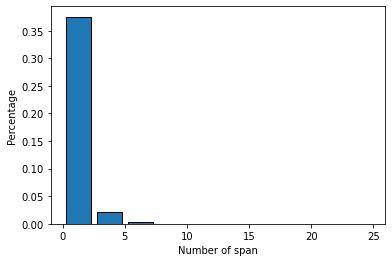

In [22]:
# Distribution histogram plot
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

fig, ax = plt.subplots()

ax.hist(len_span, density=True, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.ylabel('Percentage')
plt.xlabel('Number of span');

# Word embedding

In [23]:
# Read embedding
word_dict = []
embeddings_index = {}
f = open('/home/harsh/Downloads/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')


GloVe data loaded


In [24]:
words = word_dict
num_words = len(words)

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
idx2word = {i: w for w, i in word_to_index.items()}

In [25]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [26]:
 # mapping for token cases
case2Idx = {'1': 1, '0': 0}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

char2Idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char2Idx[c] = len(char2Idx)

# Data pre-processing 

In [27]:
from sklearn.model_selection import train_test_split

y = data['seq']
X = data['text']

y_test = test['seq']
X_test = test['text']

In [28]:
#train test
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.1)

In [29]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer


from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from nltk.corpus import stopwords
import re
import numpy as np

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    text_data = text_data.lower()
    return tknzr2.tokenize(text_data)

def preprocess(text):
    text = text.lower()

    word_list = nltk.word_tokenize(text)
    lemma = WordNetLemmatizer()

    for w in word_list:
        w = lemma.lemmatize(w)

    new_text = ""
    for w in word_list:
        new_text = new_text + " " + w

    return new_text

def encoding(X, y, isTest = True):
    sentences = []
    
    for t in X:
        sentences.append(custom_tokenizer(t))

    X = []
    for s in sentences:
        sent = []
        for w in s:
            try:
                w = w.lower()
                sent.append(word_to_index[w])
            except:
                sent.append(word_to_index["UNK"])
        X.append(sent)
           
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

    if isTest:
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=word_to_index["PAD"])
        y = to_categorical(y, num_classes=2)
    else:
        y = None

    return (X,y)


def decoding(text_data, encoding_text, prediction):
    test = [[idx2word[i] for i in row] for row in encoding_text]

    lst_token = []

    for t in range(0, len(test)):
        yy_pred = []
        for i in range(0, len(test[t])):
            if prediction[t][i] == 1:
                yy_pred.append(test[t][i])
        lst_token.append(yy_pred)

    lis_idx = []
    for i in range(0, len(text_data)):
        idx = []
        for t in lst_token[i]:
            index = text_data[i].find(t)
            idx.append(index)
            for j in range(1, len(t)):
                index = index + 1
                idx.append(index)
        lis_idx.append(idx)

    return lis_idx

[nltk_data] Downloading package punkt to /home/harsh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/harsh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.
2022-12-20 19:40:37.983463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 19:40:37.983485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [30]:
X1, y1 = encoding(X_train, y_train)
X2, y2 = encoding(X_dev, y_dev)
X3, y3 = encoding(X_test, y_test)

In [31]:
# Illustrating the data transforming 
x_t, y_t = encoding(X, y)

print(custom_tokenizer(X[7926]))
print(X[7926])
print(x_t[7926])

print(y[7926])

['i', 'only', 'use', 'the', 'word', 'haole', 'when', 'stupidity', 'and', 'arrogance', 'is', 'involved', 'and', 'not', 'all', 'the', 'time', '.', 'excluding', 'the', 'potus', 'of', 'course', '.']
I only use the word haole when stupidity and arrogance is involved and not all the time.  Excluding the POTUS of course.
[    12    216    718     15    894 724236     94  17046     28  48680
     34   6187     28     80     77     15    137      3  81507     15
  34058     41   1605      3      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0   

# Detection

In [33]:
from tensorflow import keras

In [36]:
from tensorflow.keras.models import Sequential

In [41]:
tf.compat.v1.disable_eager_execution()
print(tf.compat.v1.get_default_graph())

In [44]:
import keras
import keras.utils
from keras import utils as np_utils

In [45]:
!pip install tensorflow==1.13.1

ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==1.13.1


In [46]:
# BiLSTM - CRF 
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.layers import Input
from keras_contrib.layers import CRF
from keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

# from keras.metrics import BinaryAccuracy, Precision, Recall, AUC
max_len =128
input = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=True)(input)

model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units = max_len, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(max_len, activation="relu"))(model)
crf = CRF(2)  
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=['accuracy'])

model.summary()

plot_model(model,to_file="bilstm-crf.pdf",show_shapes=True,show_layer_names=True)

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [ ]:
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

checkpointer = ModelCheckpoint(filepath = 'drive/My Drive/CODE/SemVal/model/model_detection_19.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

model.fit(X1, np.array(y1), batch_size=64, epochs=15, validation_data=(X2, y2), callbacks=[checkpointer])




Train on 7766 samples, validate on 863 samples
Epoch 1/15





7766/7766 [==============================] - 66s 8ms/step - loss: 0.1088 - acc: 0.9736 - val_loss: 0.0888 - val_acc: 0.9778
Epoch 2/15
7766/7766 [==============================] - 60s 8ms/step - loss: 0.0937 - acc: 0.9736 - val_loss: 0.0825 - val_acc: 0.9790
Epoch 3/15
7766/7766 [==============================] - 59s 8ms/step - loss: 0.0864 - acc: 0.9736 - val_loss: 0.0783 - val_acc: 0.9797
Epoch 4/15
7766/7766 [==============================] - 58s 8ms/step - loss: 0.0812 - acc: 0.9736 - val_loss: 0.0746 - val_acc: 0.9797
Epoch 5/15
7766/7766 [==============================] - 60s 8ms/step - loss: 0.0761 - acc: 0.9736 - val_loss: 0.0734 - val_acc: 0.9794
Epoch 6/15
7766/7766 [==============================] - 59s 8ms/step - loss: 0.0718 - acc: 0.9736 - val_loss: 0.0698 - val_acc: 0.9798
Epoch 7/15
7766/7766 [==============================] - 59s 8ms/step - loss: 0.0666 - acc: 0.9736 - val_loss: 0.0690 - val_acc: 0.9798


# Evaluation

In [ ]:
# Load bi-LSTM model

from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

# load model
model = load_model('drive/My Drive/CODE/SemVal/model/model_detection_4.h5', custom_objects={'CRF':CRF,'crf_loss':crf_loss,'crf_accuracy':crf_accuracy})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
y_pred = model.predict(X3)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y3, -1)
# y_pred = [[i for i in row] for row in y_pred]

In [ ]:
# return back
test = [[idx2word[i] for i in row] for row in X3]

In [ ]:
yy_pred = []
yy_test = []

for i in range(0, len(test[0])):
    if y_pred[0][i] == 1:
        yy_pred.append(test[0][i])

for i in range(0, len(test[0])):
    if y_test_true[0][i] == 1:
        yy_test.append(test[0][i])

print(yy_pred)
print(yy_test)

['sexist', 'rubbish']
['abnormal', 'sexist', 'rubbish']


In [ ]:
raw_y = decoding(X_test, X3, y_pred)

In [ ]:
f1(raw_y[0], spans_test[0])

acc = []
for i in range(0, len(spans_test)):
    acc.append(f1(raw_y[i], spans_test[i]))

print(np.mean(acc)*100)

61.320465302853854


In [ ]:
# Make CSV file for itegrate BERT 
new_sub = pd.DataFrame({'id': test_id, 'text': text_data_test, 'spans': raw_y, 'span_true': spans_test})

new_sub.to_csv('drive/My Drive/CODE/SemVal/test_demo_detection.csv', index=False)

# Submission

In [ ]:
# Load bi-LSTM model

from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

# load model
model = load_model('drive/My Drive/CODE/SemVal/model/model_detection_4.h5', custom_objects={'CRF':CRF,'crf_loss':crf_loss,'crf_accuracy':crf_accuracy})

In [ ]:
SUBMIUSSION = 'drive/My Drive/CODE/SemVal/dataset/tsd_test.csv'

subm = pd.read_csv(SUBMIUSSION)
subm_text = subm['text']
subm_id = subm.index

In [ ]:
X4, y4 = encoding(subm_text, None, isTest=False)

y_sub = model.predict(X4)
y_sub = np.argmax(y_sub, axis=-1)

raw_subm = decoding(subm_text, X4, y_sub)

In [ ]:
# Make CSV file 
new_sub = pd.DataFrame({'id': subm_id, 'text': subm_text, 'spans': raw_subm})

new_sub.to_csv('drive/My Drive/CODE/SemVal/submission_detection.csv', index=False)

In [ ]:
# make sure that the ids match the ones of the scores
predictions = raw_subm
ids = subm_id

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")